In [1]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import NELL
import networkx as nx
from networkx.algorithms import community
from IPython.display import display
from torch_geometric.utils import to_dense_adj

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
data_dir = "../data/NELL"
os.makedirs(data_dir, exist_ok=True)

dataset = NELL(root=data_dir)
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Number of nodes: 65755
Number of edges: 251550
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/n4/jaehwan/anaconda3/envs/pyg/lib/python3.10/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'test_mask', 'edge_index', 'x', 'val_mask', 'train_mask', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [3]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
print(edge_example)

(2, 251550)
[[   30    30]
 [ 8949 18582]]


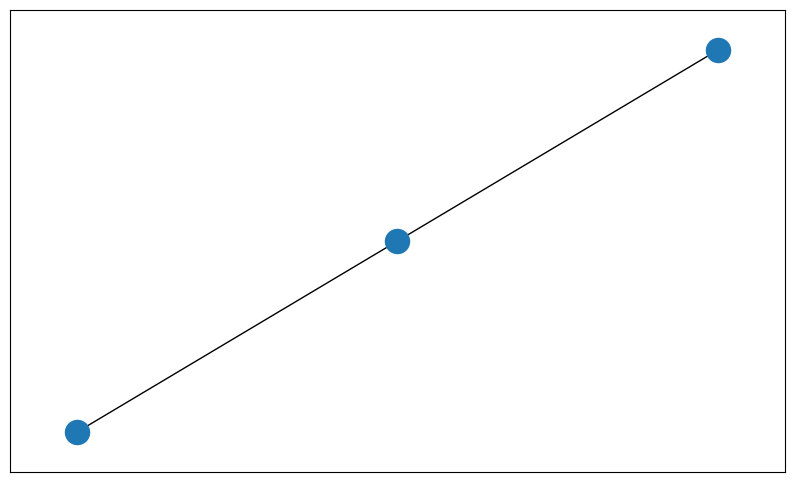

In [4]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)

In [5]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average node degree: 3.90

Average node degree: 3.83


,count,mean,std,min,25%,50%,75%,max
0,65755.0,3.83,43.04,1.0,1.0,1.0,2.0,4549.0


65755
251550


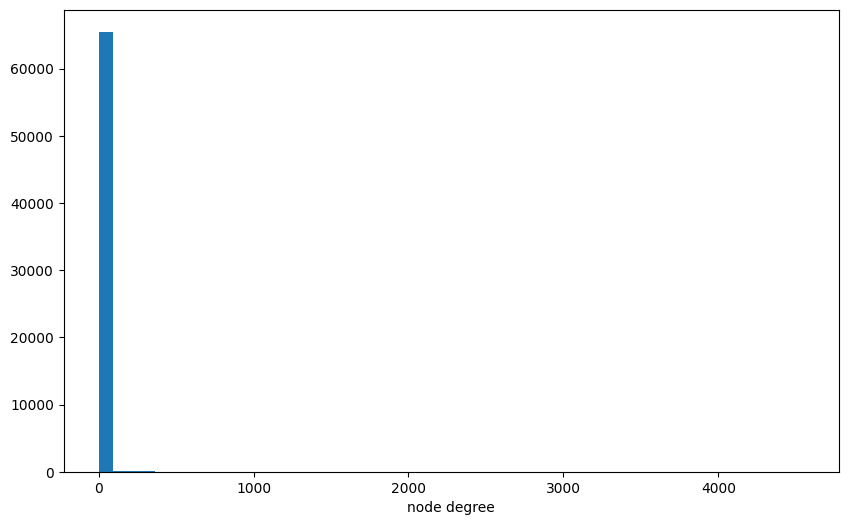

In [6]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

### Feature Matrix

In [7]:
data.x

SparseTensor(row=tensor([    0,     0,     0,  ..., 65752, 65753, 65754]),
             col=tensor([    0,     1,     2,  ..., 61275, 61276, 61277]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(65755, 61278), nnz=426664, density=0.01%)

In [8]:
dense_data = data.x.to_dense()
dense_data

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 4., 0.,  ..., 0., 0., 0.],
        [1., 2., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

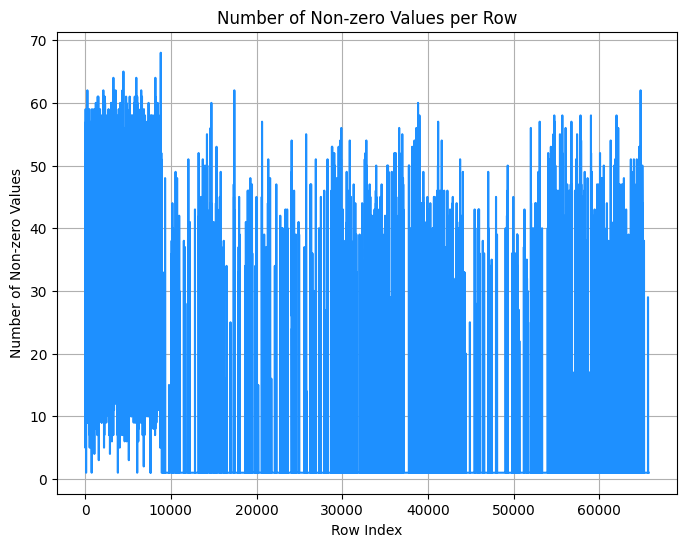

In [9]:
import numpy as np
import matplotlib.pyplot as plt

non_zero_counts = np.count_nonzero(dense_data, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(len(non_zero_counts)), non_zero_counts, color='dodgerblue', linestyle='-') 
plt.xlabel('Row Index')
plt.ylabel('Number of Non-zero Values')
plt.title('Number of Non-zero Values per Row')
plt.grid(True)
plt.show()

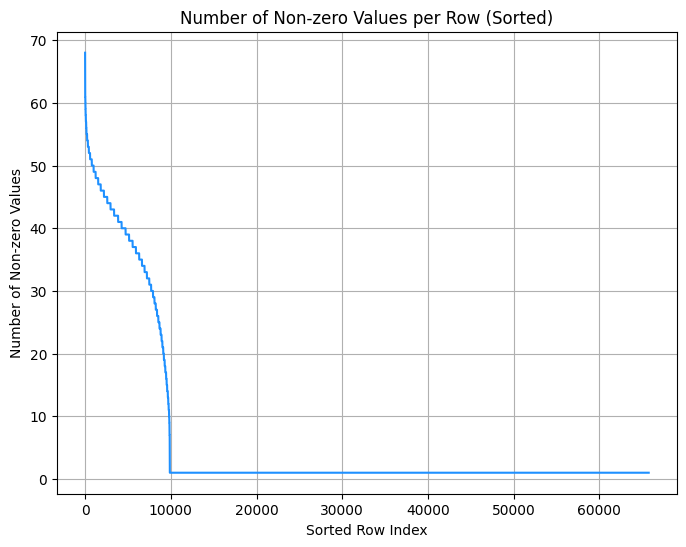

In [10]:
# 각 행의 non-zero 값 개수 세기
non_zero_counts = np.count_nonzero(dense_data, axis=1)

# 내림차순으로 정렬된 인덱스
sorted_indices = np.argsort(non_zero_counts)[::-1]  # 내림차순으로 정렬된 인덱스

# 정렬된 순서에 맞게 데이터 정렬
sorted_non_zero_counts = non_zero_counts[sorted_indices]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(len(sorted_non_zero_counts)), sorted_non_zero_counts, color='dodgerblue', linestyle='-')  # 선 그래프로 변경
plt.xlabel('Sorted Row Index')
plt.ylabel('Number of Non-zero Values')
plt.title('Number of Non-zero Values per Row (Sorted)')
plt.grid(True)
plt.show()

### Adjacency Matrix

In [11]:
data.edge_index.shape

torch.Size([2, 251550])

In [12]:
adj = to_dense_adj(data.edge_index)
adj = adj.view(data.num_nodes, -1).numpy()
adj.shape

/home/n4/jaehwan/anaconda3/envs/pyg/lib/python3.10/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'test_mask', 'edge_index', 'x', 'val_mask', 'train_mask', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


(65755, 65755)

In [13]:
adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

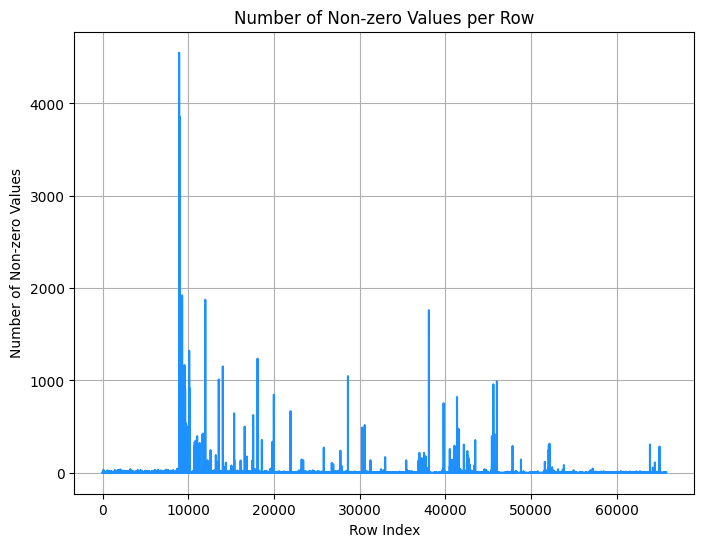

In [14]:
import numpy as np
import matplotlib.pyplot as plt

non_zero_counts = np.count_nonzero(adj, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(len(non_zero_counts)), non_zero_counts, color='dodgerblue', linestyle='-') 
plt.xlabel('Row Index')
plt.ylabel('Number of Non-zero Values')
plt.title('Number of Non-zero Values per Row')
plt.grid(True)
plt.show()

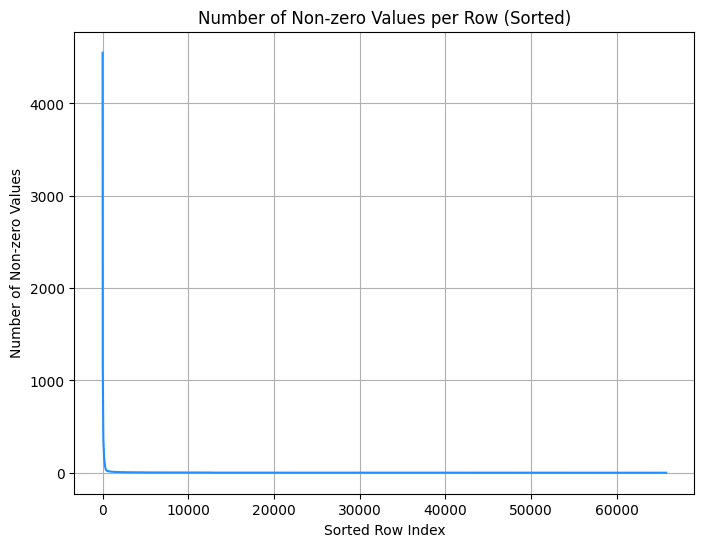

In [15]:
# 각 행의 non-zero 값 개수 세기
non_zero_counts = np.count_nonzero(adj, axis=1)

# 내림차순으로 정렬된 인덱스
sorted_indices = np.argsort(non_zero_counts)[::-1]  # 내림차순으로 정렬된 인덱스

# 정렬된 순서에 맞게 데이터 정렬
sorted_non_zero_counts = non_zero_counts[sorted_indices]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(len(sorted_non_zero_counts)), sorted_non_zero_counts, color='dodgerblue', linestyle='-')  # 선 그래프로 변경
plt.xlabel('Sorted Row Index')
plt.ylabel('Number of Non-zero Values')
plt.title('Number of Non-zero Values per Row (Sorted)')
plt.grid(True)
plt.show()

In [16]:
# 각 행의 non-zero 값 개수 세기
non_zero_counts = np.count_nonzero(adj, axis=1)

# non_zero_counts 값이 0인 특정 row 찾기
zero_count_rows = np.where(non_zero_counts == 0)[0]

# non_zero_counts 값이 0인 행의 개수와 인덱스 출력
print(f"non_zero_counts 값이 0인 행의 개수: {len(zero_count_rows)}")
print(f"non_zero_counts 값이 0인 행의 인덱스: {zero_count_rows}")

non_zero_counts 값이 0인 행의 개수: 0
non_zero_counts 값이 0인 행의 인덱스: []
